In [2]:
# Multimedia and ML Project - Image Splicing Detection
# Courtesy: Kaggle for Dataset  & https://github.com/himanshurawlani for Visualizing of Layer Output
# Deepthi J and Yaswanth Gadmsetti, B.Tech CSE (CYS)
# Mentored and Guided by: Ramaguru Radhakrishnan, Assistant Professor, Sr. Gr.
# TIFAC-CORE in Cyber Security, Amrita Vishwa Vidyapeetham, Coimbatore

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import glob
import math
%matplotlib inline

In [3]:
import torch
#!pip install torch_dct
import torch_dct as dct
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

In [4]:
import albumentations as A
import cv2 as cv

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
from scipy.ndimage import rotate, filters
from skimage.color import rgb2gray

In [6]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, accuracy_score

In [7]:
!PYTORCH_NO_CUDA_MEMORY_CACHING=1
#!pip install -U albumentations
import albumentations as A
#!pip install kornia
import kornia as K
from sklearn import metrics
import torch.utils.model_zoo as model_zoo
from kornia import morphology as morph
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

'PYTORCH_NO_CUDA_MEMORY_CACHING' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
seed = 200
torch.backends.cudnn.deterministic = True
!CUBLAS_WORKSPACE_CONFIG=:16:8
torch.backends.cudnn.benchmark = False
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.is_available()

'CUBLAS_WORKSPACE_CONFIG' is not recognized as an internal or external command,
operable program or batch file.


False

In [10]:
batch = 5
num_epochs = 1

In [11]:
class keywords:
    TData_train = "D:/YASWANTH/input/defactotrainset/defacto_trainset.xlsx"
    VData_test = "D:/YASWANTH/input/defactotestset/defacto_testset.xlsx"
    #VData_test1 = "D:/YASWANTH/input/defactotestset/defacto_testset1.xlsx"
    splicing_img = "D:/YASWANTH/input/defactosplicing/splicing_2_img/img/"
    splicing = "D:/YASWANTH/input/defactosplicing/splicing_2_annotations/probe_mask"
    #splicing_img1 = "D:/YASWANTH/input/defactosplicing/splicing_1_img/img/"
    #splicing1 = "D:/YASWANTH/input/defactosplicing/splicing_1_annotations/probe_mask"
    casia_model_path = "D:/YASWANTH/input/casia-model/Model.pth"
    TRAIN = 'train'

In [12]:
def prepare(im_root_dir, lab_root_dir, num=2000, mode='test'):
    """
    Prepare the data by reading from Excel and sorting the names and labels.

    Args:
        im_root_dir (str): Root directory for image data.
        lab_root_dir (str): Root directory for label data.
        num (int, optional): Number of data samples to load (default: 2000).
        mode (str, optional): Mode of the dataset (default: 'test').

    Returns:
        tuple: Tuple containing the sorted names and labels.
    """
    name = []
    lab = []

    # Read the data from the Excel
    df = pd.read_excel(im_root_dir)

    # Read the column with name 'name'
    zipta = df['name'].tolist()

    labels = sorted(os.listdir(lab_root_dir))

    for fname in zipta:
        lab_ = [a for a in labels if fname in a]
        lab.append(lab_)

    name = sorted(zipta)
    label = sorted(lab)

    return name, label

In [13]:
transformi = transforms.Compose([
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], p=1)
], p=0.05)


class dataset(torch.utils.data.Dataset):
    """
    Custom dataset class for image data.
    """

    def __init__(self, im_root_dir, label_root_dir, num, mode='test', transform=None, tra=None):
        """
        Initialize the dataset.

        Args:
            im_root_dir (str): Root directory for image data.
            label_root_dir (str): Root directory for label data.
            num (int): Number of data samples to load.
            mode (str, optional): Mode of the dataset (default: 'test').
            transform: Transformation to apply to the data (default: None).
            tra: Additional transformation parameter (default: None).
        """
        self.im_root_dir = im_root_dir
        self.label_root_dir = label_root_dir
        self.transform = transform
        self.tra = tra
        self.num = num
        self.mode = mode
        name = []
        lab = []
        name, label = prepare(self.im_root_dir, self.label_root_dir, self.num, self.mode)
        self.name = name
        self.label = label

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.name)

    def transform0(self, sample):
        """
        Apply transformation to the image and mask.

        Args:
            sample (tuple): Tuple containing the image and mask.

        Returns:
            tuple: Transformed image and mask.
        """
        image, mask = sample[0], sample[1]

        n = 256
        image = TF.resize(image, size=(n, n), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
        mask = TF.resize(mask, size=(n, n), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)

        return image, mask

    def __getitem__(self, idx):
        """
        Get a specific data sample from the dataset.

        Args:
            idx (int): Index of the data sample.

        Returns:
            dict: Dictionary containing the image and label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = torch.FloatTensor(cv.imread(f"{keywords.splicing_img}{self.name[idx][:-3]}tif"))

        label = torch.FloatTensor(cv.imread(f"{keywords.splicing}/{self.name[idx][:-3]}jpg", cv.IMREAD_GRAYSCALE))

        if len(label.shape) >= 3:
            label = torch.max(label, 2)

        if self.mode == keywords.TRAIN:
            z = self.tra(image=np.array(image), mask=(np.array(label)))
            x = torch.FloatTensor(z['image'])
            y = torch.FloatTensor(z['mask'])
            x = x.permute(2, 0, 1)
            x = self.transform(x)
            y = y.unsqueeze(0)
            x, y = self.transform0((x / 255.0, y))
            y = y.ge(0.5).float()
        else:
            x = image.permute(2, 0, 1)
            x = self.transform(x)
            y = label.unsqueeze(0) / 255.0
            x, y = self.transform0((x / 255.0, y))
            y = y.ge(0.5).float()

        return {'image': x, 'landmarks': y}

In [14]:
TData = dataset(
    keywords.TData_train,
    keywords.splicing,
    450,
    keywords.TRAIN,
    transformi,
    transform
)

train_loader = DataLoader(TData, batch_size=batch, num_workers=0, shuffle=True)

In [15]:
VData = dataset(
    keywords.VData_test,
    #keywords.VData_test1,
    keywords.splicing,
    #keywords.splicing1,
    num=85,
    transform=transformi,
    tra=transform
)

test_loader = DataLoader(VData, batch_size=4, num_workers=0, shuffle=True)

In [16]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

def calculate_pixel_f1(pd, gt):
    """
    Calculates various evaluation metrics for binary classification tasks on pixel-level data.

    Args:
        pd (torch.Tensor): Predicted output tensor of shape (N, H, W) representing the predicted labels.
        gt (torch.Tensor): Ground truth tensor of shape (N, H, W) representing the true labels.

    Returns:
        tuple: A tuple containing the following evaluation metrics:
            - F1 score (float): F1 score for the binary classification task.
            - AUC score (float): Area Under the ROC Curve score for the binary classification task.
            - Precision (float): Precision score for the binary classification task.
            - Recall (float): Recall score for the binary classification task.
            - Accuracy (float): Accuracy score for the binary classification task.
    """
    y_true = gt.view(-1).detach().cpu().numpy()
    y_score = pd.view(-1).detach().cpu().numpy()

    y_pred1 = np.array(y_score > 0.5, dtype=np.float32)
    y_pred = y_pred1
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    acc = accuracy_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred1, zero_division=1)
    try:
        AUC = roc_auc_score(y_true, y_pred1)
    except:
        print("Only one class")
        AUC = 0.0

    return F1, AUC, precision, recall, acc

In [17]:
def VGGB16(block_number, mode, *args, **kwargs):
    """
    Constructs a VGG Block (VGGB16) based on the specified block number.

    Args:
        block_number (int): Block number indicating which part of the VGG16 model to extract.
        mode (str): Mode indicating whether the model is in training or evaluation mode.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Returns:
        nn.Sequential: VGG Block (VGGB16) corresponding to the specified block number.
    """
    if mode == keywords.TRAIN:
        model = torchvision.models.vgg16_bn(pretrained=True, progress=False)
        for param in model.parameters():
            param.requires_grad = True
    else:
        with torch.no_grad():
            model = torchvision.models.vgg16_bn(pretrained=False, progress=False)

    table = {
        '1': list(model.children())[0][0:6],
        '2': list(model.children())[0][7:13],
        '3': list(model.children())[0][14:23],
        '4': list(model.children())[0][24:33],
        '5': list(model.children())[0][34:43]
    }

    return table[f'{block_number}']

In [18]:
class GDWT(nn.Module):
    """
    Generalized Discrete Wavelet Transform (GDWT) module implementation.
    """

    def __init__(self):
        """
        Initialize GDWT module.
        """
        super(GDWT, self).__init__()
        self.dwt = DWT()
        self.soft = nn.Softmax2d()

    def forward(self, x):
        """
        Forward pass of the GDWT module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying GDWT.
        """
        z = self.dwt(x)
        y = z[1] + z[2]
        y1 = self.soft(y)
        s = y1 * z[0] + z[0]
        return s

In [19]:
class VGG(nn.Module):
    """
    VGG module implementation.
    """

    def __init__(self, num, mode = keywords.TRAIN, batch=True, **kwargs):
        """
        Initialize VGG module.

        Args:
            num (int): Number of channels.
            mode (str): Mode of operation.
            batch (bool): Flag to indicate batch normalization.
            **kwargs: Additional keyword arguments.
        """
        super(VGG, self).__init__()
        self.mode = mode
        self.P1 = nn.Sequential(*(VGGB16(num, self.mode)[0:3]))
        self.P2 = nn.Sequential(*(VGGB16(num, self.mode)[3:]))
        if mode == keywords.TRAIN:
            for param in self.P1.parameters():
                param.requires_grad = True
            for param in self.P2.parameters():
                param.requires_grad = True
        self.M = GDWT()

    def forward(self, x):
        """
        Forward pass of the VGG module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through VGG.
        """
        z = self.P1(x)
        y = self.P2(z) + z
        return y

In [20]:
class DWT(nn.Sequential):
    """
    Custom module: Discrete Wavelet Transform (DWT).
    """

    def __init__(self, mode=None, *args, **kwargs):
        """
        Initialize DWT module.

        Args:
            mode (str): Mode of DWT.
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.
        """
        super(DWT, self).__init__()
        self.mode = mode

    def forward(self, x):
        """
        Forward pass of the DWT module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Transformed tensor after DWT.
        """
        x01 = x[:, :, 0::2, :] / 2
        x02 = x[:, :, 1::2, :] / 2
        x1 = x01[:, :, :, 0::2]
        x2 = x02[:, :, :, 0::2]
        x3 = x01[:, :, :, 1::2]
        x4 = x02[:, :, :, 1::2]
        x_LL = x1 + x2 + x3 + x4
        x_HL = -x1 - x2 + x3 + x4
        x_LH = -x1 + x2 - x3 + x4
        x_HH = x1 - x2 - x3 + x4
        x_High = torch.cat((x_HL.unsqueeze(2), x_LH.unsqueeze(2), x_HH.unsqueeze(2)), 2)
        if self.mode == 'high':
            return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)
        return x_LL, x_HL, x_LH, x_HH


class IDWT(nn.Sequential):
    """
    Custom module: Inverse Discrete Wavelet Transform (IDWT).
    """

    def __init__(self, *args, **kwargs):
        """
        Initialize IDWT module.

        Args:
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.
        """
        super(IDWT, self).__init__()

    def forward(self, x):
        """
        Forward pass of the IDWT module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Inverse transformed tensor after IDWT.
        """
        r = 2
        in_batch, in_channel, in_height, in_width = x.size()
        out_batch, out_channel, out_height, out_width = in_batch, int(in_channel / (r ** 2)), r * in_height, r * in_width
        x1 = x[:, 0:out_channel, :, :] / 2
        x2 = x[:, out_channel:out_channel * 2, :, :] / 2
        x3 = x[:, out_channel * 2:out_channel * 3, :, :] / 2
        x4 = x[:, out_channel * 3:out_channel * 4, :, :] / 2
        h = torch.zeros([out_batch, out_channel, out_height, out_width], requires_grad=False)
        h[:, :, 0::2, 0::2] = x1 - x2 - x3 + x4
        h[:, :, 1::2, 0::2] = x1 - x2 + x3 - x4
        h[:, :, 0::2, 1::2] = x1 + x2 - x3 - x4
        h[:, :, 1::2, 1::2] = x1 + x2 + x3 + x4
        return h


In [21]:
class ConvReluBatch(nn.Module):
    """
    Custom module: Convolutional layer followed by ReLU activation and Batch Normalization.
    """

    def __init__(self, in_channels, out_channels, *args, **kwargs):
        """
        Initialize ConvReluBatch module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(ConvReluBatch, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.M = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.ReLU(True),
            nn.BatchNorm2d(out_channels)
        )
        
    def prts(self):
        print(self.M)
    def forward(self, x):
        """
        Forward pass of the ConvReluBatch module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through Convolutional layer, ReLU activation, and Batch Normalization.
        """
        y = self.M(x)
        return y


class NConvBatch(nn.Module):
    """
    Custom module: Multiple Convolutional layers followed by Batch Normalization.
    """

    def __init__(self, in_channels, mid_channels, out_channels, n, *args, **kwargs):
        """
        Initialize NConvBatch module.

        Args:
            in_channels (int): Number of input channels.
            mid_channels (int): Number of intermediate channels.
            out_channels (int): Number of output channels.
            n (int): Number of convolutional layers.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(NConvBatch, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.n = n
        assert n > 1
        layers = []
        channels = [in_channels] + [mid_channels] * (n - 1) + [out_channels]
        for i in range(n):
            conv2d = nn.Conv2d(channels[i], channels[i + 1], *args, **kwargs)
            layers += [conv2d, nn.BatchNorm2d(channels[i + 1]), nn.ReLU(inplace=True)]
        self.M = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the NConvBatch module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through multiple Convolutional layers and Batch Normalization.
        """
        y = self.M(x)
        return y


class NConv(nn.Module):
    """
    Custom module: Multiple Convolutional layers.
    """

    def __init__(self, in_channels, mid_channels, out_channels, n, *args, **kwargs):
        """
        Initialize NConv module.

        Args:
            in_channels (int): Number of input channels.
            mid_channels (int): Number of intermediate channels.
            out_channels (int): Number of output channels.
            n (int): Number of convolutional layers.
            *args: Variable length argument list for nn.Conv2d.
            **kwargs: Arbitrary keyword arguments for nn.Conv2d.
        """
        super(NConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels
        self.n = n
        assert n > 1
        layers = []
        channels = [in_channels] + [mid_channels] * (n - 1) + [out_channels]
        for i in range(n):
            conv2d = nn.Conv2d(channels[i], channels[i + 1], *args, **kwargs)
            layers += [conv2d, nn.BatchNorm2d(channels[i + 1]), nn.ReLU(inplace=True)]
        self.M = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the NConv module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through multiple Convolutional layers.
        """
        y = self.M(x)
        return y

In [22]:
class Sobel(nn.Module):
    """
    Sobel edge detection module.
    """

    def __init__(self, in_channels, out_channels, padding, dilation):
        """
        Initialize the Sobel module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            padding (int): Amount of padding.
            dilation (int): Dilation rate.
        """
        super(Sobel, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dilation = dilation
        self.padding = padding

        # Define the Sobel filters for x and y directions
        filter_x = torch.FloatTensor([
            [1, 0, -1],
            [2, 0, -2],
            [1, 0, -1],
        ])

        filter_y = torch.FloatTensor([
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1],
        ])

        # Expand dimensions and repeat to match input and output channels
        filter_x = filter_x.unsqueeze(0).unsqueeze(0)
        filter_x = filter_x.repeat(1, self.in_channels, 1, 1)
        filter_x = filter_x.repeat(self.out_channels, 1, 1, 1)

        filter_y = filter_y.unsqueeze(0).unsqueeze(0)
        filter_y = filter_y.repeat(1, self.in_channels, 1, 1)
        filter_y = filter_y.repeat(self.out_channels, 1, 1, 1)

        # Convert filters to parameters
        filter_x = nn.Parameter(filter_x, requires_grad=False)
        filter_y = nn.Parameter(filter_y, requires_grad=False)

        # Create convolution layers for x and y directions
        conv_x = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, dilation=self.dilation, bias=False)
        conv_x.weight = filter_x

        conv_y = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding, dilation=self.dilation, bias=False)
        conv_y.weight = filter_y

        # Combine convolution layers with batch normalization
        self.sobel_x = nn.Sequential(conv_x, nn.BatchNorm2d(self.out_channels))
        self.sobel_y = nn.Sequential(conv_y, nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        """
        Forward pass of the Sobel module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying Sobel edge detection.
        """
        # Apply Sobel operators for x and y directions
        g_x = self.sobel_x(x)
        g_y = self.sobel_y(x)

        # Calculate gradient magnitude
        g = torch.sqrt(torch.pow(g_x, 2) + torch.pow(g_y, 2) + 1e-6)

        # Apply sigmoid activation
        return torch.sigmoid(g)

In [23]:
class BayarConv2dandnoise(nn.Module):
    """
    Bayar Convolutional Layer with noise.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the kernel.
        stride (int): Stride of the convolution operation.
        padding (int): Padding size.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the kernel.
        stride (int): Stride of the convolution operation.
        padding (int): Padding size.
        minus1 (torch.Tensor): Tensor of shape (in_channels, out_channels, 1) with values -1.000.
        kernel (nn.Parameter): Learnable parameter of shape (in_channels, out_channels, kernel_size ** 2 - 1).

    """

    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=2):
        super(BayarConv2dandnoise, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.minus1 = torch.ones(self.in_channels, self.out_channels, 1) * -1.000
        #torch.ones(a)
        #a -> number of coloumns

        #torch.ones(a,b)
        #a -> number of rows, b -> number of coloumns

        #torch.ones(a,b,c)
        #a -> number of main rows, b-> number of rows in each 'a' row, c -> number of coloumns.

        self.kernel = nn.Parameter(torch.rand(self.in_channels, self.out_channels, kernel_size ** 2 - 1),
                                   requires_grad=True)

    def bayarConstraint(self):
        """
        Apply Bayar constraint to the kernel parameter.

        Returns:
            torch.Tensor: Real kernel tensor after applying the Bayar constraint.

        """
        self.kernel.data = self.kernel.permute(2, 0, 1)
        self.kernel.data = torch.div(self.kernel.data, self.kernel.data.sum(0))
        self.kernel.data = self.kernel.permute(1, 2, 0)
        ctr = self.kernel_size ** 2 // 2
        real_kernel = torch.cat((self.kernel[:, :, :ctr], self.minus1.to(self.kernel.device), self.kernel[:, :, ctr:]),
                                dim=2)
        real_kernel = real_kernel.reshape((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        return real_kernel

    def forward(self, x):
        """
        Forward pass of the BayarConv2dandnoise module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the BayarConv2dandnoise operation.

        """
        x = F.conv2d(x, self.bayarConstraint(), bias=None, stride=self.stride, padding=self.padding, groups=1)
        return x

In [24]:
class _PositionAttentionModule(nn.Module):
    """
    Position attention module.

    Args:
        in_channels (int): Number of input channels.

    """

    def __init__(self, in_channels, **kwargs):
        super(_PositionAttentionModule, self).__init__()
        self.conv_b = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv_c = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv_d = nn.Conv2d(in_channels, in_channels, 1)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        Forward pass of the PositionAttentionModule.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the PositionAttentionModule.

        """
        batch_size, _, height, width = x.size()
        feat_b = self.conv_b(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        feat_c = self.conv_c(x).view(batch_size, -1, height * width)
        attention_s = self.softmax(torch.bmm(feat_b, feat_c))
        feat_d = self.conv_d(x).view(batch_size, -1, height * width)
        feat_e = torch.bmm(feat_d, attention_s.permute(0, 2, 1)).view(batch_size, -1, height, width)
        out = self.alpha * feat_e + x

        return out


class _ChannelAttentionModule(nn.Module):
    """
    Channel attention module.

    """

    def __init__(self, **kwargs):
        super(_ChannelAttentionModule, self).__init__()
        self.beta = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        Forward pass of the ChannelAttentionModule.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the ChannelAttentionModule.

        """
        batch_size, _, height, width = x.size()
        feat_a = x.view(batch_size, -1, height * width)
        feat_a_transpose = x.view(batch_size, -1, height * width).permute(0, 2, 1)
        attention = torch.bmm(feat_a, feat_a_transpose)
        attention_new = torch.max(attention, dim=-1, keepdim=True)[0].expand_as(attention) - attention
        attention = self.softmax(attention_new)

        feat_e = torch.bmm(attention, feat_a).view(batch_size, -1, height, width)
        out = self.beta * feat_e + x

        return out

In [25]:
class Sob(nn.Module):
    """
    Sobel module.

    Args:
        in_chan (int): Number of input channels.
        och (int): Number of output channels.

    """

    def __init__(self, in_chan, och, **kwargs):
        super(Sob, self).__init__()
        self.in_chan = in_chan
        self.C = ConvReluBatch(self.in_chan, och, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.sob = Sobel(self.in_chan, 1, 1, 1)

    def forward(self, x):
        """
        Forward pass of the Sob module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the Sob module.

        """
        q = self.sob(x) * x
        gama6 = self.C(q)
        return gama6

In [26]:
class EE(nn.Module):
    """
    EE module.

    Args:
        inchan (int): Number of input channels.

    """

    def __init__(self, inchan):
        super(EE, self).__init__()
        self.PA1 = _PositionAttentionModule(inchan // 2)
        self.PA2 = _PositionAttentionModule(inchan // 2)
        self.c1 = ConvReluBatch(inchan, inchan // 2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.c2 = ConvReluBatch(inchan, inchan // 2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):
        """
        Forward pass of the EE module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the EE module.

        """
        xz1 = self.c1(x)
        xz2 = self.c2(x)
        x1 = F.avg_pool2d(xz1, kernel_size=2, padding=1, stride=1)
        z1 = TF.resize(x1, (xz1.shape[2], xz1.shape[2]))
        x2 = self.PA1(xz1 + xz1 - z1)
        x3 = self.PA2(xz2)
        x5 = torch.cat((x, x2, x3), 1)
        return x5

In [27]:
class ASPD(nn.Module):
    """
    ASPD module.

    Args:
        inchan (int): Number of input channels.
        och (int): Number of output channels.
        och1 (int): Number of intermediate output channels.
        dil (list): List of dilation factors.

    """

    def __init__(self, inchan, och, och1, dil):
        super(ASPD, self).__init__()
        self.inchan = inchan
        self.dil = dil

        # Branch 1
        self.conv1 = ConvReluBatch(inchan, och, kernel_size=3, stride=1, dilation=self.dil[0], padding=self.dil[0],
                                     bias=False)
        self.conv11 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[0], padding=self.dil[0],
                                      bias=False)
        self.conv111 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[0], padding=self.dil[0],
                                       bias=False)

        # Branch 2
        self.conv2 = ConvReluBatch(inchan, och, kernel_size=3, stride=1, dilation=self.dil[1], padding=self.dil[1],
                                     bias=False)
        self.conv22 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[1], padding=self.dil[1],
                                      bias=False)
        self.conv222 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[1], padding=self.dil[1],
                                       bias=False)

        # Branch 3
        self.conv3 = ConvReluBatch(inchan, och, kernel_size=3, stride=1, dilation=self.dil[2], padding=self.dil[2],
                                     bias=False)
        self.conv33 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[2], padding=self.dil[2],
                                      bias=False)
        self.conv333 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[2], padding=self.dil[2],
                                       bias=False)

        # Branch 4
        self.conv4 = ConvReluBatch(inchan, och, kernel_size=3, stride=1, dilation=self.dil[3], padding=self.dil[3],
                                     bias=False)
        self.conv44 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[3], padding=self.dil[3],
                                      bias=False)
        self.conv444 = ConvReluBatch(och, och, kernel_size=3, stride=1, dilation=self.dil[3], padding=self.dil[3],
                                       bias=False)

    def forward(self, x):
        """
        Forward pass of the ASPD module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the ASPD module.

        """
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)

        x11 = self.conv11(x1 + x2)
        x22 = self.conv22(x2 + x1 + x3)
        x33 = self.conv33(x3 + x2 + x4)
        x44 = self.conv44(x4 + x3)

        x111 = self.conv111(x11 + x22)
        x222 = self.conv222(x22 + x11 + x33)
        x333 = self.conv333(x33 + x22 + x44)
        x444 = self.conv444(x44 + x33)

        x5 = torch.cat((x111, x222, x333, x444), 1)
        return x5

In [28]:
class NoiseBlock(nn.Module):
    """
    NoiseBlock module.

    Args:
        inchan (int): Number of input channels.
        midchan (int): Number of intermediate channels.
        d (int): Dilation factor for the backward noise block.

    """

    def __init__(self, inchan, midchan, d=1, **kwargs):
        super(NoiseBlock, self).__init__()
        self.inchan = inchan
        self.midchan = midchan

        # Forward noise block
        self.NoiseF = ConvReluBatch(self.inchan, self.midchan, kernel_size=3, padding=1, bias=False)

        # Backward noise block
        self.NoiseB = NConvBatch(self.midchan, self.midchan, self.midchan, 2, kernel_size=3, padding=d,
                                   dilation=d, bias=False)

        # Gradient Domain Wavelet Transform
        self.M = GDWT()

    def forward(self, x):
        """
        Forward pass of the NoiseBlock module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the NoiseBlock module.

        """
        x1 = self.NoiseF(x)
        x2 = self.NoiseB(x1)
        x3 = x1 + x2

        if self.inchan == 3:
            x3 = self.M(x3)

        return x3

In [29]:
class WUNet(nn.Module):
    """
    WUNet module.

    Args:
        mode (str): Mode of the WUNet module.

    """

    def __init__(self, mode='TRAIN'):
        super(WUNet, self).__init__()
        self.mode = mode

        # Noise layer
        self.noise = BayarConv2dandnoise(3, 3)

        # Gradient Domain Wavelet Transform
        self.M1 = GDWT()
        self.M2 = GDWT()
        self.M3 = GDWT()
        self.M4 = GDWT()
        self.M5 = GDWT()
        self.M6 = GDWT()
        self.M7 = GDWT()
        self.M8 = GDWT()

        # One21 convolution
        self.one21 = ConvReluBatch(64, 64, kernel_size=3, stride=2, padding=1, bias=False)

        # One22 convolution
        self.one22 = ConvReluBatch(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # One23 convolution
        self.one23 = ConvReluBatch(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # Two22 convolution
        self.two22 = ConvReluBatch(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # Two23 convolution
        self.two23 = ConvReluBatch(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # None21 convolution
        self.none21 = ConvReluBatch(64, 64, kernel_size=3, stride=2, padding=1, bias=False)

        # None22 convolution
        self.none22 = ConvReluBatch(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # None23 convolution
        self.none23 = ConvReluBatch(64, 64, kernel_size=3, stride=4, padding=1, bias=False)

        # Ntwo22 convolution
        self.ntwo22 = ConvReluBatch(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # Ntwo23 convolution
        self.ntwo23 = ConvReluBatch(128, 128, kernel_size=3, stride=2, padding=1, bias=False)

        # CD1 convolution
        self.cd1 = ConvReluBatch(128, 64, kernel_size=3, padding=1, bias=False)

        # CD2 convolution
        self.cd2 = ConvReluBatch(320, 128, kernel_size=3, padding=1, bias=False)

        # CD3 convolution
        self.cd3 = ConvReluBatch(448, 256, kernel_size=3, padding=1, bias=False)

        # NCD1 convolution
        self.ncd1 = ConvReluBatch(128, 64, kernel_size=3, padding=1, bias=False)

        # NCD2 convolution
        self.ncd2 = ConvReluBatch(320, 128, kernel_size=3, padding=1, bias=False)

        # NCD3 convolution
        self.ncd3 = ConvReluBatch(448, 256, kernel_size=3, padding=1, bias=False)

        # ASPD1 module
        self.ASPD1 = ASPD(512, 256, 512, [1, 3, 6, 12, 18])

        # Sob1 module
        self.so1 = Sob(64, 3)

        # Sob2 module
        self.so2 = Sob(64, 3)

        # Sob3 module
        self.so3 = Sob(128, 1)

        # Sob4 module
        self.so4 = Sob(128, 1)

        # Sob5 module
        self.so5 = Sob(256, 1)

        # Sob6 module
        self.so6 = Sob(256, 1)

        # EE module
        self.En1 = EE(1024)

        # Conve1 convolution
        self.Conve1 = nn.Conv2d(2048, 1, kernel_size=1, padding=0, bias=False)

        # Conve31 convolution
        self.Conve31 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        # Coeve1 convolution
        self.Coeve1 = nn.Conv2d(64, 1, kernel_size=1, padding=0, bias=False)

        # Coeve31 convolution
        self.Coeve31 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

        ################ Seg part

        # VGG1 module
        self.c1 = VGG(1, self.mode)

        # VGG2 module
        self.c2 = VGG(2, self.mode)

        # VGG3 module
        self.c3 = VGG(3, self.mode)

        # VGG4 module
        self.s1 = VGG(1, self.mode)

        # VGG5 module
        self.s2 = VGG(2, self.mode)

        # VGG6 module
        self.s3 = VGG(3, self.mode)

        # NoiseBlock1 module
        self.n1 = NoiseBlock(3, 16)

        # NoiseBlock2 module
        self.n2 = NoiseBlock(16, 32)

        # NoiseBlock3 module
        self.n3 = NoiseBlock(32, 64)

        # Upsampling layer
        self.os1 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        # Upsampling layer
        self.up = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

        # Upsampling layer
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Upsampling layer
        self.up2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        ##############################
        self.CH = _ChannelAttentionModule()

        if self.mode == keywords.TRAIN:
            for m in self.modules():
                if (isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d)) and \
                        (m not in self.c1.modules()) and (m not in self.c2.modules()) and \
                        (m not in self.c3.modules()) and (m not in self.s1.modules()) and \
                        (m not in self.s2.modules()) and (m not in self.s3.modules()):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d) and \
                        (m not in self.c1.modules()) and (m not in self.c2.modules()) and \
                        (m not in self.c3.modules()) and (m not in self.s1.modules()) and \
                        (m not in self.s2.modules()) and (m not in self.s3.modules()):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
    # Apply noise to the input image
    w = self.noise(x)

    # Store intermediate outputs
    layer_outputs = {}

    # Stage 1
    x1 = self.c1(x)
    layer_outputs['x1'] = x1
    x2_ = self.M1(x1)
    x2 = self.cd1(torch.cat((x2_, self.one21(x1)), 1))
    layer_outputs['x2'] = x2

    y1 = self.s1(w)
    layer_outputs['y1'] = y1
    y2_ = self.M2(y1)
    y2 = self.ncd1(torch.cat((y2_, self.none21(y1)), 1))
    layer_outputs['y2'] = y2

    s1 = self.n1(self.so1(y2) * self.so2(x2))

    # Stage 2
    x3 = self.c2(x2 + y2)
    layer_outputs['x3'] = x3
    x4_ = self.M3(x3)
    x4 = self.cd2(torch.cat((x4_, self.one22(x1), self.two22(x3)), 1))
    layer_outputs['x4'] = x4

    y3 = self.s2(y2 + x2)
    layer_outputs['y3'] = y3
    y4_ = self.M4(y3)
    y4 = self.ncd2(torch.cat((y4_, self.none22(y1), self.ntwo22(y3)), 1))
    layer_outputs['y4'] = y4

    s2 = self.n2(s1 * (self.so3(y4) * self.so4(x4)))

    # Stage 3
    x6_ = self.c3(x4 + y4)
    layer_outputs['x6_'] = x6_
    x6 = self.cd3(torch.cat((x6_, self.one23(x1), self.two23(x3)), 1))
    layer_outputs['x6'] = x6

    y6_ = self.s3(y4 + x4)
    layer_outputs['y6_'] = y6_
    y6 = self.ncd3(torch.cat((y6_, self.none23(y1), self.ntwo23(y3)), 1))
    layer_outputs['y6'] = y6

    s3 = self.n3(s2 * (self.so5(y6) * self.so6(x6)))

    # Combine the output of stage 3
    com = torch.cat((x6, y6), 1)
    a6 = self.ASPD1(com)
    aa1 = self.En1(a6)
    aa2 = self.CH(aa1)

    # Final convolution for enhanced image
    x66 = self.Conve1(aa2)
    x25 = self.os1(x66)

    # Convolution for segmentation
    s66 = self.Coeve1(s3)

    # Store the final outputs
    layer_outputs['x25'] = x25
    layer_outputs['s66'] = s66

    return x25, s66, layer_outputs


import matplotlib.pyplot as plt

# Assuming 'outputs' is the dictionary containing the layer outputs
x1_output = outputs['x1']

# Convert the tensor to a numpy array
x1_output_np = x1_output.detach().numpy()

# Display the output as an image
plt.imshow(x1_output_np[0], cmap='gray')
plt.show()

In [30]:
class DiceBCELoss(nn.Module):
    """
    Combination of Dice loss and BCE (Binary Cross-Entropy) loss for segmentation tasks.
    """
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.BCE = nn.BCEWithLogitsLoss(reduction='mean')
        self.BCE1 = nn.BCEWithLogitsLoss(reduction='mean')
        self.BCE2 = nn.BCEWithLogitsLoss(reduction='mean')
        self.BCEE = nn.BCEWithLogitsLoss(reduction='mean')
    
    def forward(self, inputs, targets, smooth=1):
        """
        Calculate the combined Dice loss and BCE loss.

        Args:
            inputs (tuple): Tuple containing the input tensors (segmentation, edge) for the model.
            targets (tensor): Target tensor for the segmentation task.
            smooth (float): Smoothing factor for Dice loss.

        Returns:
            dice_bce_loss (tensor): Combined Dice loss and BCE loss.

        Note:
            The inputs should be in the format (segmentation, edge).

        """
        # Calculate gradients using Sobel filter
        targete = K.filters.sobel(targets, normalized=True, eps=1e-05)
        
        # Resize and reshape the targets and gradients for different scales
        targete1 = TF.resize(targete, (64, 64)).reshape(-1)
        targets1 = TF.resize(targets, (16, 16)).reshape(-1)
        targets2 = TF.resize(targets, (28, 28)).reshape(-1)
        targets = targets.reshape(-1)
        targets2 = targets2.reshape(-1)
        targete = targete.reshape(-1)
        
        # Flatten and convert inputs to float
        Binputs = inputs[0].reshape(-1).float()
        BinputsE = inputs[1].reshape(-1).float()
        
        # Apply sigmoid to inputs for edge and segmentation
        inputs_edge = torch.sigmoid(inputs[1].reshape(-1)).float()
        inputs_seg = torch.sigmoid(inputs[0].reshape(-1)).float()

        # Calculate Dice loss for segmentation
        intersection = (inputs_seg * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_seg.sum() + targets.sum() + smooth)
        
        # Calculate Dice loss for edge detection
        intersection1 = (inputs_edge * targete1).sum()
        dice_loss1 = 1 - (2. * intersection1 + smooth) / (inputs_edge.sum() + targete1.sum() + smooth)
        
        # Calculate BCE loss for segmentation
        BCE = self.BCE(Binputs, targets)
        
        # Calculate CEL (Cross-entropy loss) for segmentation
        in1 = inputs_seg - inputs_seg * targets
        in2 = targets - targets * inputs_seg
        CEL = (in1.sum() + in2.sum()) / (inputs_seg.sum() + targets.sum())
        
        # Calculate weighted combination of BCE and Dice losses
        Dice_BCE = 0.01 * BCE + 0.6 * dice_loss + dice_loss1
        
        return Dice_BCE

In [31]:
criterion = DiceBCELoss()
print(criterion)

DiceBCELoss(
  (BCE): BCEWithLogitsLoss()
  (BCE1): BCEWithLogitsLoss()
  (BCE2): BCEWithLogitsLoss()
  (BCEE): BCEWithLogitsLoss()
)


In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = WUNet(keywords.TRAIN).to(device)
optimizer = optim.Adam(params=net.parameters(), lr=0.0002)
exp_lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [50, 90], gamma=0.1, verbose=True)
import torch
import torchvision.transforms as transforms

# Load pre-trained model checkpoint
checkpoint = torch.load(keywords.casia_model_path, map_location=device)
net.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
exp_lr_scheduler.load_state_dict(checkpoint['scheduler'])

def visualize_tensor(tensor):
    # Check if the input is a tuple
    if isinstance(tensor, tuple):
        # Iterate through each tensor in the tuple and visualize it
        for i in range(len(tensor)):
            visualize_tensor(tensor[i])
        return

    # Convert the tensor to a NumPy array
    array = tensor.detach().cpu().numpy()

    # Transpose the array if needed (e.g., for images)
    if array.shape[0] == 3:  # Assuming the tensor represents RGB images
        array = array.transpose(1, 2, 0)
        
    # Check the number of channels
    if array.shape[0] == 1:
        # If single-channel, squeeze the array to remove the channel dimension
        array = np.squeeze(array, axis=2)

    # Display the tensor
    plt.imshow(array, cmap='gray')
    plt.show()


# Load the WUNet model from the checkpoint
model = net
checkpoint = torch.load(keywords.casia_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

# Create a transform to preprocess the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to the desired dimensions
    transforms.ToTensor()  # Convert the image to a tensor
])

# Load and preprocess the input image
image = Image.open("0_000000195755a.tif")  # Replace with the path to your image
input_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
print(input_tensor)
# Pass input through the model
outputs = model(input_tensor)

# Visualize outputs from each module
visualize_tensor(outputs)


Adjusting learning rate of group 0 to 2.0000e-04.
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2471, 0.2471, 0.2392],
          [0.0000, 0.0000, 0.0000,  ..., 0.2510, 0.2510, 0.2471],
          [0.0000, 0.0039, 0.0039,  ..., 0.2471, 0.2471, 0.2510],
          ...,
          [0.2235, 0.1333, 0.0588,  ..., 0.7176, 0.7216, 0.7098],
          [0.3294, 0.2118, 0.0980,  ..., 0.7529, 0.7529, 0.7490],
          [0.3922, 0.2667, 0.1373,  ..., 0.7255, 0.7294, 0.7333]],

         [[0.4431, 0.4431, 0.4471,  ..., 0.6118, 0.6118, 0.6118],
          [0.4431, 0.4471, 0.4471,  ..., 0.6157, 0.6157, 0.6118],
          [0.4392, 0.4431, 0.4431,  ..., 0.6118, 0.6118, 0.6157],
          ...,
          [0.2902, 0.2039, 0.1490,  ..., 0.7098, 0.7176, 0.7059],
          [0.3843, 0.2784, 0.1804,  ..., 0.7451, 0.7529, 0.7490],
          [0.4353, 0.3216, 0.2157,  ..., 0.7255, 0.7294, 0.7373]],

         [[0.7294, 0.7294, 0.7333,  ..., 0.8824, 0.8824, 0.8784],
          [0.7294, 0.7333, 0.7333,  ..., 0.8863, 0.8863, 0

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [34]:
import torch
import matplotlib.pyplot as plt

class SaveBestModel:
    """Class to save the best model based on validation loss during training."""

    def __init__(self, best_valid_loss=float('inf')):
        """
        Initialize the SaveBestModel object.

        Args:
            best_valid_loss (float, optional): Best validation loss. Default is infinity.

        """
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer, exp_lr_scheduler):
        """
        Call method to save the best model based on validation loss.

        Args:
            current_valid_loss (float): Current validation loss.
            epoch (int): Current epoch.
            model (torch.nn.Module): Model to be saved.
            optimizer (torch.optim.Optimizer): Optimizer used for training.
            exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.

        """
        if current_valid_loss < self.best_valid_loss and epoch > 30:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': exp_lr_scheduler.state_dict()
            }, 'Model.pth')

# Create an instance of SaveBestModel
bestloss = SaveBestModel()

In [35]:
from torch.cuda.amp import GradScaler, autocast

gradient_accumulations = 4

def train_model(num_epoch, model, traindata, validata):
    """
    Function to train the model.

    Args:
        num_epoch (int): Number of epochs.
        model (torch.nn.Module): Model to be trained.
        traindata (DataLoader): DataLoader for training data.
        validata (DataLoader): DataLoader for validation data.

    Returns:
        tuple: Train loss, validation loss, accuracy, F1 score, recall, and precision.

    """
    scaler = GradScaler()
    train_loss_values = []
    valid_loss_values = []
    train_loss = 0
    acc1 = 0
    ft1 = 0
    pr1 = 0
    re1 = 0

    if torch.cuda.is_available():
        model.train().cuda()
    else:
        model.train()

    min_valid_loss = np.inf

    for batch_idx, (data) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data['image'].cuda(), data['landmarks'].cuda()
        else:
            data, target = data['image'], data['landmarks']

        output = model(data)

        loss = criterion(output, target).float()
        train_loss = train_loss + loss.item()
        f1, AUC, pr, re, acc = calculate_pixel_f1(torch.sigmoid(output[0]), target)
        acc1 = acc1 + acc
        ft1 = ft1 + f1
        pr1 = pr1 + pr
        re1 = re1 + re

        (loss).backward()
        optimizer.step()
        optimizer.zero_grad()

        print('TEpoch {}: [{}/{} ({:.0f}%)]- Loss: {:.8f} - f1:{:.6f} - acc:{:.6f} - reca:{:.6f} - pre:{:.6f}'.format(
            num_epoch + 1, (batch_idx) * batch, (len(train_loader.dataset)),
            100. * ((batch_idx)) / (len(train_loader)), loss.item(), f1, acc, re, pr))

    train_loss_values.append(train_loss / len(TData))
    val_loss = evali(num_epoch, model, validata, optimizer, exp_lr_scheduler)
    valid_loss_values.append(val_loss[0] / len(VData))
    exp_lr_scheduler.step()

    return train_loss / (batch_idx + 1), val_loss[0], acc1 / (batch_idx + 1), val_loss[1], ft1 / (batch_idx + 1), val_loss[2], re1 / (batch_idx + 1), val_loss[3], pr1 / (batch_idx + 1), val_loss[4]

def evali(num_epoch, model, validata, optimizer=None, exp_lr_scheduler=None):
    """
    Function to evaluate the model on validation data.

    Args:
        num_epoch (int): Number of epochs.
        model (torch.nn.Module): Model to be evaluated.
        validata (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer, optional): Optimizer used for training. Default is None.
        exp_lr_scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Default is None.

    Returns:
        tuple: Validation loss, accuracy, F1 score, recall, and precision.

    """
    print("\nValidation Part:\n")
    valid_loss = 0.0
    aucv = 0
    fv1 = 0
    vrec = 0
    vpr = 0

    model.eval()

    for batch_idx, (data) in enumerate(validata):
        if torch.cuda.is_available():
            datas, labels = data['image'].cuda(), data['landmarks'].cuda()
        else:
            datas, labels = data['image'], data['landmarks']

        target = model(datas)
        vloss = criterion(target, labels).float()
        valid_loss = (vloss).item() + valid_loss
        f1, AUC, pr, re, acc = calculate_pixel_f1(torch.sigmoid(target[0]), labels)
        aucv = aucv + acc
        fv1 = fv1 + f1
        vrec = vrec + re
        vpr = vpr + pr

        print('VEpoch {}: [{}/{} ({:.0f}%)]  -  Loss: {:.8f}  -  f1:{:.6f}  -  acc:{:.6f}'.format(
            num_epoch + 1, (batch_idx) * batch, (len(test_loader.dataset)),
            100. * ((batch_idx)) / (len(test_loader)), vloss.item(), f1, AUC))

    bestloss(valid_loss / (batch_idx + 1), num_epoch, model, optimizer, exp_lr_scheduler)

    return valid_loss / (batch_idx + 1), aucv / (batch_idx + 1), fv1 / (batch_idx + 1), vrec / (batch_idx + 1), vpr / (batch_idx + 1)

In [ ]:
torch.autograd.set_detect_anomaly(True)

# Training loop
for n in range(num_epochs):
    print(f"{n+1}\nTraining Part\n")
    
    # Train the model
    loss, vloss, auc, vauc, f1, vf1, rec, vrec, pr, vpr = train_model(n, net, train_loader, test_loader)
    
    print("---------------------------------------")
    print(
        "TLoss Total: {:.8f} - acc: {:.8f} - f1: {:.6f} - recall: {:.6f} - precision: {:.9f}".format(
            loss, auc, f1, rec, pr
        )
    )
    print(
        "VLoss Total: {:.8f} - validacc: {:.8f} - validF1: {:.6f} - Vrecall: {:.6f} - Vprecision: {:.9f}".format(
            vloss, vauc, vf1, vrec, vpr
        )
    )
    print("-------------------------------------------------\n")


# Predict

In [36]:
def make_predictions(data_loader, model):
    """
    Make predictions on a given data loader using the provided model.

    Args:
        data_loader (DataLoader): Data loader containing the input data.
        model (nn.Module): Model used for making predictions.

    Returns:
        output1 (Tensor): Predicted output for the first task.
        output2 (Tensor): Predicted output for the second task.
        data1 (Tensor): Input data for the first task.
        data2 (Tensor): Input data for the second task.
        ground_truth (Tensor): Ground truth data for comparison.

    """
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of data from the data loader
    data = next(iter(data_loader))

    # Extract the input images and landmarks from the data
    if torch.cuda.is_available():
        data1 = data['image'].cuda()
        data2 = data['landmarks'].cuda()
    else:
        data1 = data['image']
        data2 = data['landmarks']
    
    # Forward pass through the model
    if torch.cuda.is_available():
        output = model(data1).cuda()
    else:
        output = model(data1)
    
    # Process the output
    output1 = torch.sigmoid(output[0]).squeeze(1)
    output1 = output1.squeeze(1)
    output2 = torch.sigmoid(output[1]).squeeze(1)
    output2 = output2.squeeze(1)

    # Return the predictions, input data, and ground truth
    return output1, output2, data1, data2, data2

In [37]:
test1, test2, data1, data2, val_loss = make_predictions(test_loader, net)

# Uncomment the following lines if you want to print the validation loss
# print("VLoss Total:{:.8f} - validacc:{:.8f} - validF1:{:.6f} - Vrecall:{:.6f} - Vprecision:{:.9f}".format(val_loss[0], val_loss[1], val_loss[2], val_loss[3], val_loss[4]))
# print("-------------------------------------------------")


C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


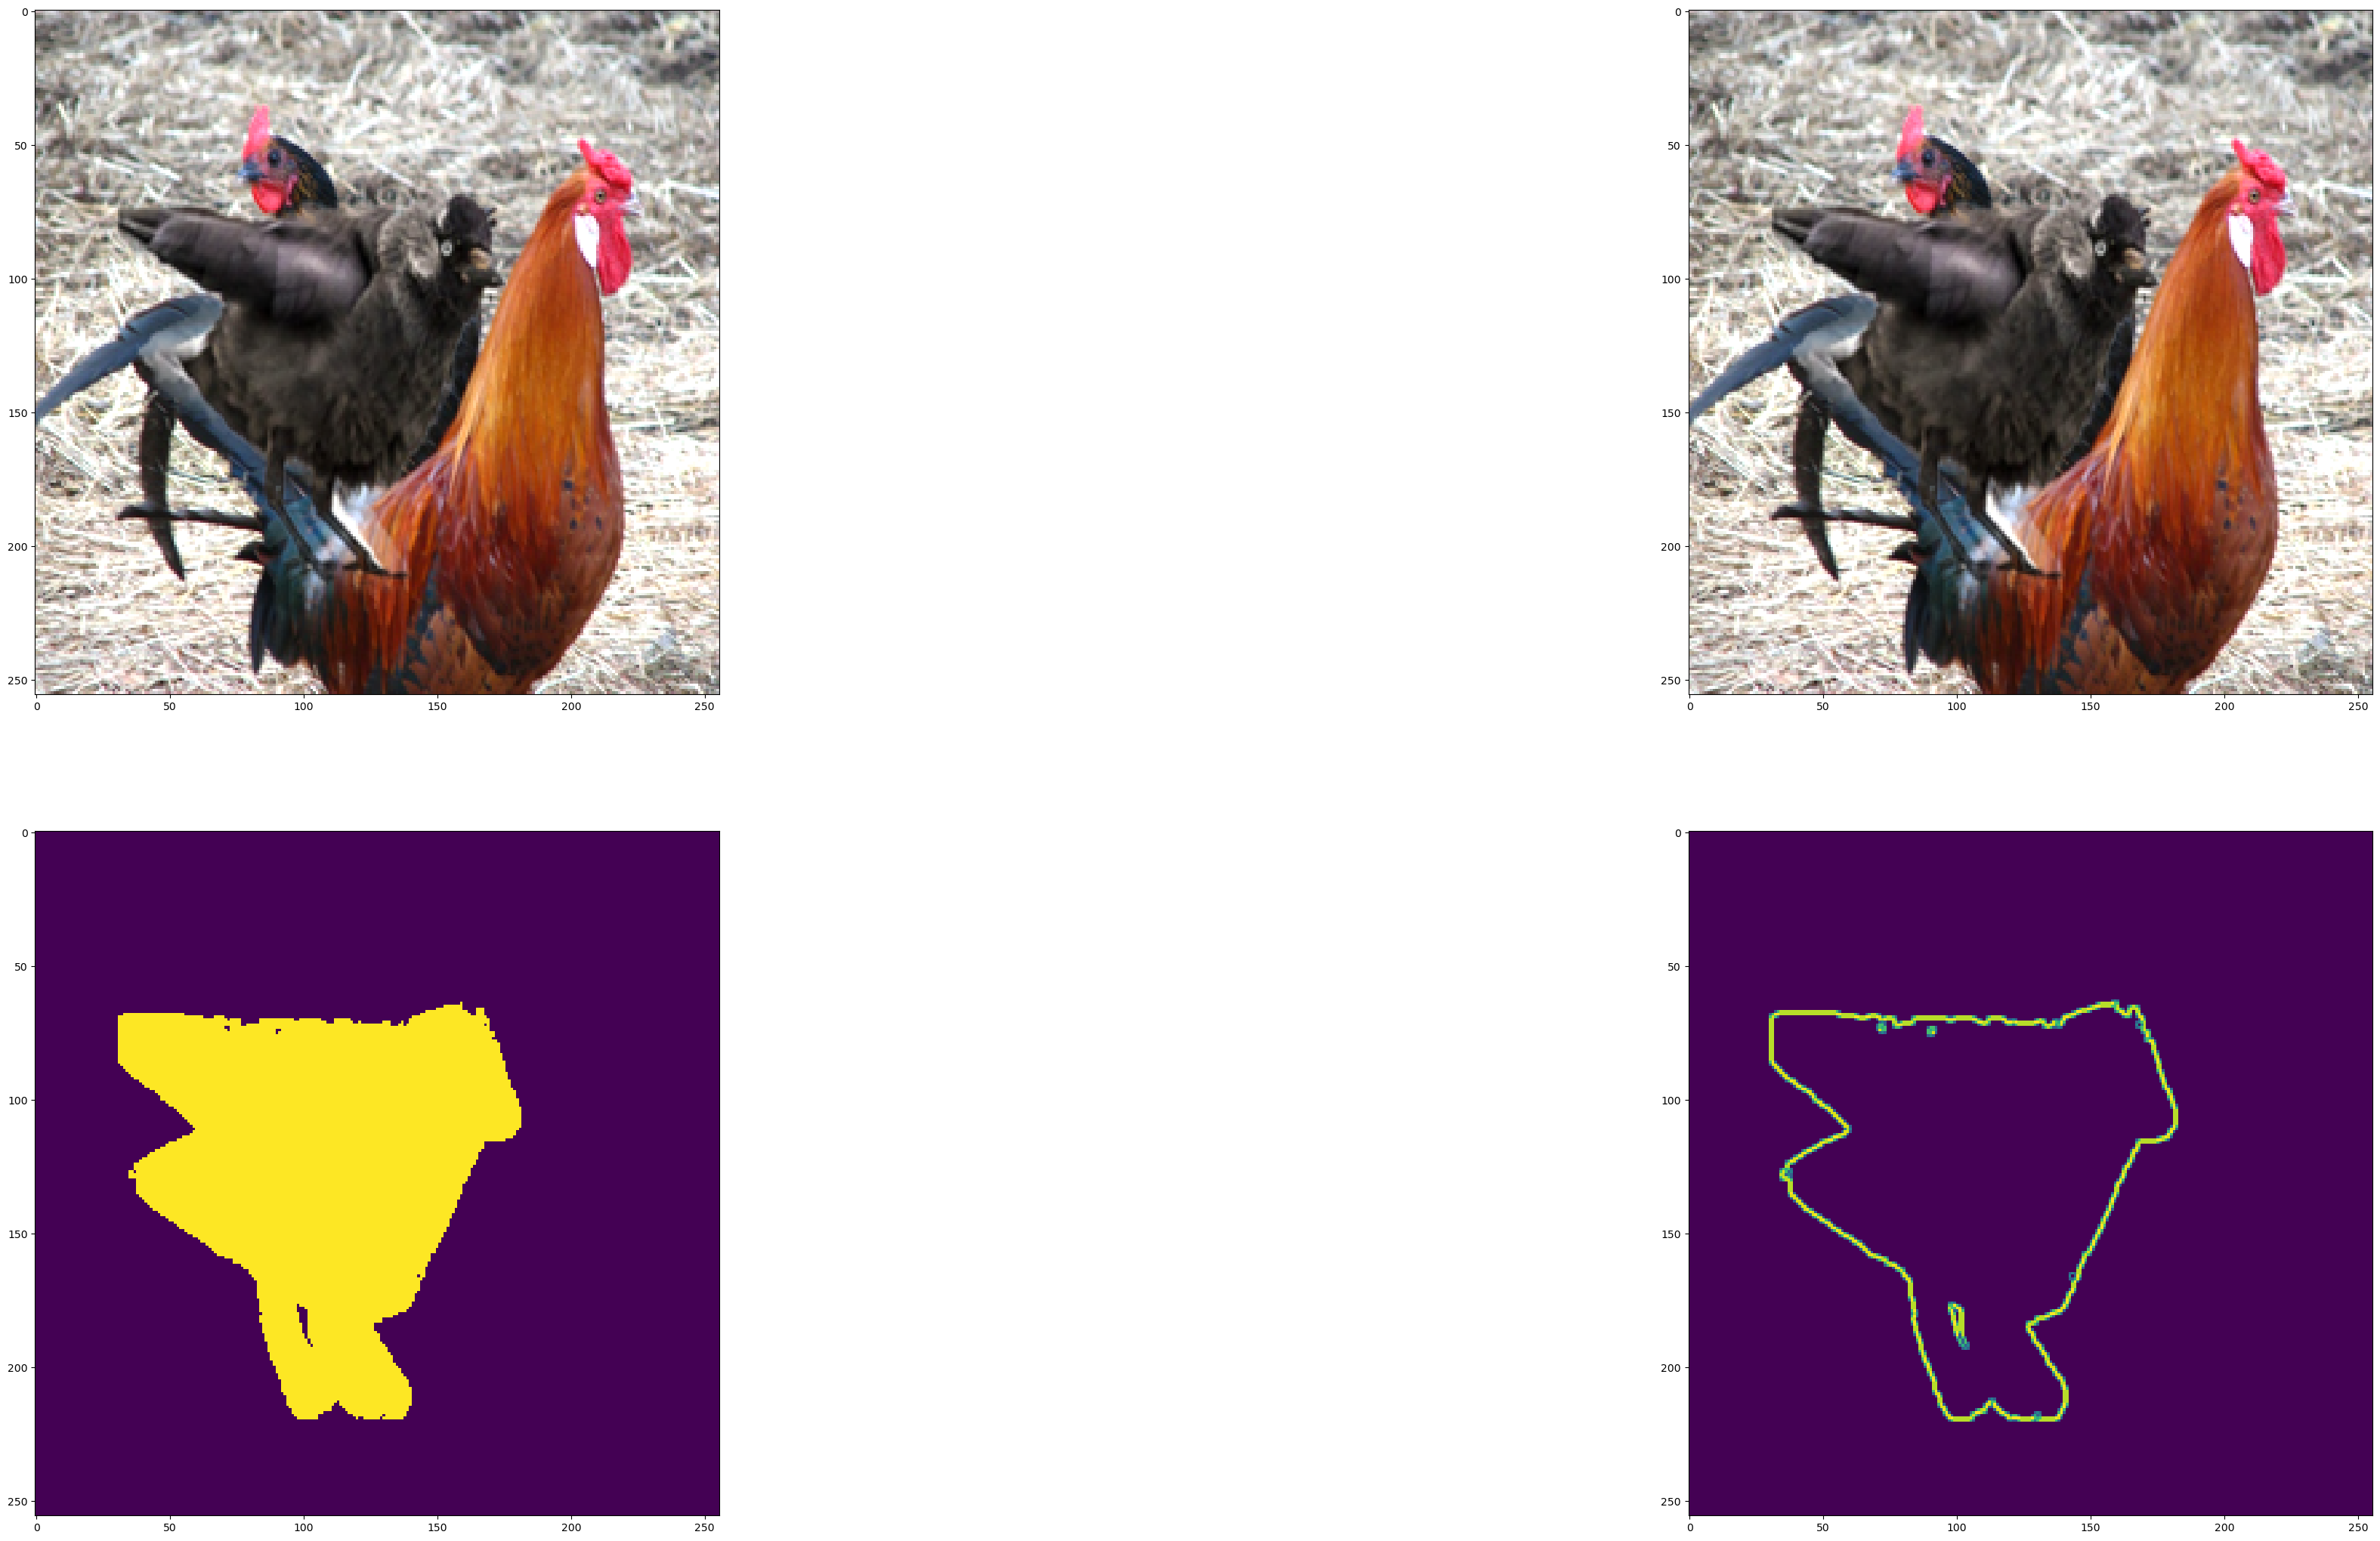

In [38]:
n = 0

# Create a figure with a specified size
plt.figure(figsize=(40, 40))

# Plot the first subplot
plt.subplot(3, 3, 1)
# Extract and normalize the image data
a = np.array(np.transpose(data1[n, :, :, :].cpu(), (1, 2, 0)) / 4)
# Display the image
plt.imshow(a[:, :, ::-1])

# Plot the second subplot
plt.subplot(3, 3, 4)
# Extract the target data from data2
cc2 = (((data2[n, 0, :, :])))  # Assuming data2 is already on the CPU
# Display the target data
plt.imshow(cc2.cpu().detach())  # Convert to CPU before using imshow

# Plot the third subplot
plt.subplot(3, 3, 3)
# Extract and normalize the image data (same as the first subplot)
a4 = np.array(np.transpose(data1[n, :, :, :].cpu(), (1, 2, 0)) / 4)
# Display the image
plt.imshow(a4[:, :, ::-1])

# Plot the fourth subplot
plt.subplot(3, 3, 6)
# Apply the Sobel edge filter to the target data (assuming edge is already on the CPU)
edge = K.filters.sobel(data2)
cc6 = np.array((edge[n, 0, :, :].cpu().detach()))
# Display the filtered target data
plt.imshow(cc6)

# Uncomment the following lines if you want to save the figure as an image
# plt.savefig('Output_image_b_' + f'{batch}' + '_number_of_epochs_' + f'{num_epochs}' + '.png')


In [38]:
#torch.save(net.state_dict(), 'Model_b_'+f'{batch}'+'_epochs_number_'+f'{num_epochs}'+'.pth')

In [39]:
#print(torch.load("C://Users//yaswa//Downloads//code//Model_b_10_epochs_number_1.pth", map_location=device))

In [40]:
#import pickle 
#pickle.dump(net, open('C:\\Users\\yaswa\\Downloads\\code\\Model_b_'+f'{batch}'+'_epochs_number_'+f'{num_epochs}'+'.pkl', 'wb'))

In [40]:
#print(net.eval())

In [77]:
from torchsummary import summary

model = WUNet()
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
BayarConv2dandnoise-1          [-1, 3, 128, 128]               0
            Conv2d-2         [-1, 64, 128, 128]           1,792
       BatchNorm2d-3         [-1, 64, 128, 128]             128
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
               VGG-8         [-1, 64, 128, 128]               0
         Softmax2d-9           [-1, 64, 64, 64]               0
             GDWT-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,864
             ReLU-12           [-1, 64, 64, 64]               0
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    ConvReluBatch-14           [-1, 64

In [93]:
import matplotlib.pyplot as plt

def visualize_tensor(tensor):
    # Check if the input is a tuple
    if isinstance(tensor, tuple):
        # Iterate through each tensor in the tuple and visualize it
        for i in range(len(tensor)):
            visualize_tensor(tensor[i])
        return

    # Convert the tensor to a NumPy array
    array = tensor.detach().cpu().numpy()

    # Transpose the array if needed (e.g., for images)
    if array.shape[0] == 3:  # Assuming the tensor represents RGB images
        array = array.transpose(1, 2, 0)
        
    # Check the number of channels
    if array.shape[1] == 1:
        # If single-channel, squeeze the array to remove the channel dimension
        array = np.squeeze(array, axis=1)

    # Display the tensor
    plt.imshow(array, cmap='gray')
    plt.show()
    


input_tensor = torch.randn(1, 3, 256, 256)

# Pass input through the model and visualize outputs
output = model(input_tensor)
print(output)  # Print the shape of the final output tensor

# Visualize outputs from each module
visualize_tensor(output)  # Replace with your visualization code
visualize_tensor(model.M1.output_tensor)
visualize_tensor(model.M2.output_tensor)
visualize_tensor(model.M3.output_tensor)
visualize_tensor(model.M4.output_tensor)
visualize_tensor(model.M5.output_tensor)
visualize_tensor(model.M6.output_tensor)

(tensor([[[[-6.3832e-01, -5.0972e-01, -3.8111e-01,  ..., -4.7595e-01,
           -6.3673e-01, -7.9751e-01],
          [-5.8968e-01, -4.7464e-01, -3.5959e-01,  ..., -3.6436e-01,
           -5.0313e-01, -6.4191e-01],
          [-5.4104e-01, -4.3956e-01, -3.3807e-01,  ..., -2.5276e-01,
           -3.6953e-01, -4.8631e-01],
          ...,
          [-2.3911e-01, -4.3873e-01, -6.3834e-01,  ..., -4.0630e-01,
           -5.4198e-01, -6.7766e-01],
          [ 2.4587e-05, -2.4091e-01, -4.8185e-01,  ..., -3.9072e-01,
           -5.1165e-01, -6.3259e-01],
          [ 2.3916e-01, -4.3096e-02, -3.2535e-01,  ..., -3.7515e-01,
           -4.8133e-01, -5.8751e-01]]]], grad_fn=<UpsampleBilinear2DBackward0>), tensor([[[[-0.1182, -0.0383, -0.0939,  ..., -0.0529, -0.0964, -0.1465],
          [-0.3270, -0.2460,  0.0401,  ..., -0.3208, -0.1358, -0.1382],
          [-0.1889, -0.2255, -0.1914,  ..., -0.0403, -0.1982, -0.1318],
          ...,
          [-0.1593, -0.1934, -0.0494,  ...,  0.1846,  0.4005,  0.065

AttributeError: 'GDWT' object has no attribute 'output_tensor'

In [87]:
# Import the necessary modules
from keras import models

#print(model)
print(model.M1)
# Extract the outputs of the top 8 layers of the model
# This will allow us to access the intermediate layer activations
layer_outputs = [layer.output for layer in model.layers[1:]]
print(layer_outputs)

# Create a new model that takes the same input as the original model
# and outputs the activations of the specified layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model


GDWT(
  (dwt): DWT()
  (soft): Softmax2d()
)


AttributeError: 'WUNet' object has no attribute 'layers'

In [48]:
img_path = "0_000000195755a.tif"

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import keras.utils as image
import numpy as np

# Load the image from the specified path and resize it to the target size
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_tensor = image.img_to_array(img)

# Add an extra dimension to the tensor to match the model's input shape
img_tensor = np.expand_dims(img_tensor, axis=0)

# Normalize the image by dividing by 255 (to scale the pixel values between 0 and 1)
img_tensor /= 255.

# Print the shape of the image tensor
# The shape should be (1, 224, 224, 3) since we have a single image with 3 color channels (RGB)
print(img_tensor.shape)


(1, 224, 224, 3)


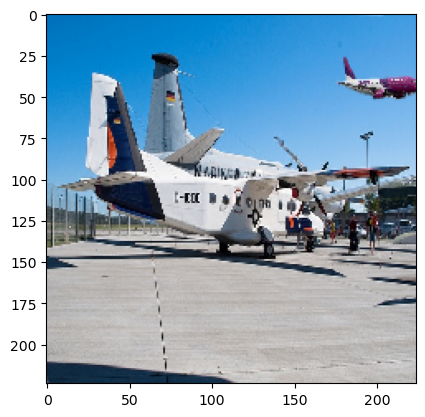

In [49]:
import matplotlib.pyplot as plt

# Display the preprocessed image
plt.imshow(img_tensor[0])
plt.show()

In [56]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[1:][::-1]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model


In [57]:
# This will return a list of 5 Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

ValueError: in user code:

    File "C:\Users\yaswa\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\yaswa\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\yaswa\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\yaswa\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "C:\Users\yaswa\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\yaswa\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 3, 256, 256), found shape=(None, 224, 224, 3)


## torch visualization

In [43]:
writer = SummaryWriter("torchlogs/")
#model = Net()
model = WUNet()

# Create dummy input data
batch_size = 4
channels = 3
height = 256
width = 256
dummy_input = torch.randn(batch_size, channels, height, width)

# Add graph to TensorBoard
writer.add_graph(model, dummy_input)

writer.close()

C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\yaswa\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or

In [ ]:
#tensorboard --logdir=./

In [44]:
#!pip install visualkeras

## Keras visualization

In [44]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers

model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(3,256,256),activation='relu'))
#model.add(Conv2D(64,(3,3),input_shape=(3,256,256),activation='relu',in_channels=3, out_channels=64, stride=1, padding=2))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 254, 64)        147520    
                                                                 
Total params: 147,520
Trainable params: 147,520
Non-trainable params: 0
_________________________________________________________________


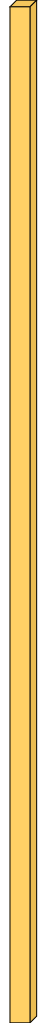

In [45]:
import visualkeras
visualkeras.layered_view(model)